In [1]:
from fractions import Fraction
from functools import wraps
import json
import logging
import inspect

from typing import Any, Callable, Dict, List, Optional, Tuple, Union
import warnings

from qiskit import IBMQ, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.algorithms.optimizers import OptimizerResult
from qiskit.circuit import Barrier, Gate, Instruction, Measure, Parameter
from qiskit.circuit.library import UGate, U3Gate, CXGate, TwoLocal
from qiskit.opflow.primitive_ops.pauli_op import PauliOp
from qiskit.opflow.primitive_ops.pauli_sum_op import PauliSumOp
from qiskit.primitives import SamplerResult, EstimatorResult
from qiskit_aer.jobs import AerJob
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_provider import IBMProvider, IBMProviderError
from qiskit.quantum_info import SparsePauliOp, Statevector
from networkx.classes import Graph
from qiskit_ibm_provider.job import IBMCircuitJob as IBMQJob
from qiskit.qobj import PulseQobj, QasmQobj
from qiskit.result import ProbDistribution, QuasiDistribution
from qiskit.algorithms.minimum_eigensolvers.vqe import VQEResult

from networkx import Graph


ValidationResult = Tuple[bool, Optional[Union[str, int, float]]]


class MaxContentError(BaseException):
    def __init__(self, content_length: int, max_content_length: int) -> None:
        self.message = f'Max content length ({max_content_length}) exceeded: {content_length}'

    def __str__(self) -> str:
        return self.message


class QObjEncoder(json.encoder.JSONEncoder):
    def default(self, obj: Any) -> Any:
        import numpy as np

        if isinstance(obj, np.integer):
            return {'__class__': 'np.integer', 'int': int(obj)}
        if isinstance(obj, np.floating):
            return {'__class__': 'np.floating', 'float': float(obj)}
        if isinstance(obj, np.ndarray):
            return {'__class__': 'np.ndarray', 'list': obj.tolist()}
        if isinstance(obj, complex):
            return {'__class__': 'complex', 're': obj.real, 'im': obj.imag}
        if isinstance(obj, Fraction):
            return {'__class__': 'Fraction', 'numerator': obj.numerator, 'denominator': obj.denominator}
        if isinstance(obj, Parameter):
            return {'__class__': 'Parameter', 'name': obj.name, 'uuid': str(obj._uuid)}

        return json.JSONEncoder.default(self, obj)


def circuit_to_dict(
    qc: QuantumCircuit,
    parameter_binds: Optional[List[Dict[Parameter, float]]] = None
) -> Dict[str, Any]:
    from qiskit import assemble
    if not parameter_binds:
        qobj = assemble(qc)
    else:
        qobj = assemble(qc, parameter_binds=parameter_binds)
    return qobj.to_dict()


def circuit_to_json(
    qc: Union[TwoLocal, QuantumCircuit],
    parameter_binds: Optional[List] = None,
    byte_string: bool = False
) -> str:
    if not byte_string and not isinstance(qc, TwoLocal) and (qc.num_parameters == 0 or parameter_binds is not None):
        circuit = circuit_to_dict(qc, parameter_binds)
        byte_string = False
    else:
        import pickle
        circuit = pickle.dumps(qc).decode('ISO-8859-1')
        byte_string = True

    return json.dumps({
        'qc': circuit,
        'byte_string': byte_string
    }, cls=QObjEncoder)


def qobj_to_json(qobj: Union[PulseQobj, QasmQobj]) -> str:
    return json.dumps(qobj.to_dict(), cls=QObjEncoder)


def sparsepauliop_to_json(op: SparsePauliOp) -> str:
    return json.dumps(op.to_list(), cls=QObjEncoder)


def paulisumop_to_json(op: PauliSumOp) -> str:
    return json.dumps(op.primitive.to_list(), cls=QObjEncoder)


def pauliop_to_json(op: PauliOp) -> str:
    return json.dumps({
        'primitive': op.primitive.to_label(),
        'coeff': op.coeff
    }, cls=QObjEncoder)


def noisemodel_to_json(noise_model: NoiseModel) -> str:
    return json.dumps(noise_model.to_dict(), cls=QObjEncoder)


def optimizerresult_to_json(
    op: OptimizerResult
) -> str:
    result = {}
    for name, value in inspect.getmembers(op):
        if (
            not name.startswith('_')
            and not inspect.ismethod(value)
            and not inspect.isfunction(value)
            and hasattr(op, name)
        ):
            result[name] = value
    return json.dumps(result, cls=QObjEncoder)


def samplerresult_to_json(
    op: SamplerResult
) -> str:
    return json.dumps({
        'metadata': op.metadata,
        'quasi_dists': [quasidistribution_to_json(d) for d in op.quasi_dists]
    }, cls=QObjEncoder)


def graph_to_json(
    g: Graph
) -> str:
    return json.dumps({
        'nodes': list(g.nodes(data=True)),
        'edges': list(g.edges(data=True))
    }, cls=QObjEncoder)


def estimatorresult_to_json(
    op: EstimatorResult
) -> str:
    return json.dumps({
        'metadata': op.metadata,
        'values': op.values
    }, cls=QObjEncoder)


def quasidistribution_to_json(
    op: QuasiDistribution
) -> str:
    return json.dumps({
        'data': str(op),
        'shots': op.shots if hasattr(op, 'shots') else None,
        'stddev_upper_bound': op.stddev_upper_bound if hasattr(op, 'stddev_upper_bound') else None
    }, cls=QObjEncoder)

def probdistribution_to_json(
    op: ProbDistribution
) -> str:
    return json.dumps({
        'data': str(op),
        'shots': op.shots,
    }, cls=QObjEncoder)
    
def vqeresult_to_json(
    result: VQEResult
) -> str:
    return json.dumps({
        'eigenvalue': result.eigenvalue
        # TODO: figure out what other parmeters need to be included
    }, cls=QObjEncoder)


def to_json(result: Any, skip: List[str] = []) -> str:
    if result is None:
        return ''
    as_dict = {}
    import inspect
    for name, value in inspect.getmembers(result):
        if not name.startswith('_') and name not in skip and \
                not inspect.ismethod(value) and not inspect.isfunction(value):
            as_dict[name] = value

    return json.dumps(as_dict, cls=QObjEncoder)


def cached(key_function: Callable) -> Callable:
    def _decorator(f: Any) -> Callable:
        f.__cache = {}
        @wraps(f)
        def _decorated(*args: Any, **kwargs: Any) -> int:
            key = key_function(*args, **kwargs)
            if key not in f.__cache:
                f.__cache[key] = f(*args, **kwargs)
            return f.__cache[key]
        return _decorated
    return _decorator


def gate_key(gate: Gate) -> Tuple[str, int]:
    return gate.name, gate.num_qubits


@cached(gate_key)
def gate_cost(gate: Gate) -> int:
    if isinstance(gate, (UGate, U3Gate)):
        return 1
    elif isinstance(gate, CXGate):
        return 10
    elif isinstance(gate, (Measure, Barrier)):
        return 0
    return sum(map(gate_cost, (g for g, _, _ in gate.definition.data)))


def compute_cost(circuit: Union[Instruction, QuantumCircuit]) -> int:
    print('Computing cost...')
    circuit_data = None
    if isinstance(circuit, QuantumCircuit):
        circuit_data = circuit.data
    elif isinstance(circuit, Instruction):
        circuit_data = circuit.definition.data
    else:
        raise Exception(f'Unable to obtain circuit data from {type(circuit)}')

    return sum(map(gate_cost, (g for g, _, _ in circuit_data)))


def uses_multiqubit_gate(circuit: QuantumCircuit) -> bool:
    circuit_data = None
    if isinstance(circuit, QuantumCircuit):
        circuit_data = circuit.data
    elif isinstance(circuit, Instruction) and circuit.definition is not None:
        circuit_data = circuit.definition.data
    else:
        raise Exception(f'Unable to obtain circuit data from {type(circuit)}')

    for g, _, _ in circuit_data:
        if isinstance(g, (Barrier, Measure)):
            continue
        elif isinstance(g, Gate):
            if g.num_qubits > 1:
                return True
        elif isinstance(g, (QuantumCircuit, Instruction)) and uses_multiqubit_gate(g):
            return True

    return False


def calc_depth(qc: QuantumCircuit) -> Tuple[int, int]:
    from qiskit.compiler import transpile

    tqc = transpile(
        qc, basis_gates=['u1', 'u2', 'u3', 'cx'], optimization_level=0
    )
    num_ops = tqc.count_ops()
    depth = tqc.depth()
    return depth, num_ops


def get_provider(
    hub: Optional[str] = None,
    group: Optional[str] = None,
    project: Optional[str] = None,
    load_account_fallback: Optional[bool] = True
) -> IBMProvider:
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')

        ibmq_logger = logging.getLogger('qiskit_ibm_provider')
        current_level = ibmq_logger.level
        ibmq_logger.setLevel(logging.ERROR)

        provider = None

        # get providers
        if hub or group or project:
            try:
                providers = IBMQ.providers()
            except IBMProviderError:
                IBMQ.load_account()
                providers = IBMQ.providers()

            # get correct provider
            for p in providers:
                if (
                    (hub in p.credentials.hub if hub else True)
                    and (group in p.credentials.group if group else True)
                    and (project in p.credentials.project if project else True)
                ):
                    # correct provider found
                    provider = p
                    break

        # handle no correct provider found
        if provider is None and load_account_fallback:
            provider = IBMQ.load_account()

        ibmq_logger.setLevel(current_level)
        return provider


def get_job(
    job_id: str,
    hub: Optional[str] = None,
    group: Optional[str] = None,
    project: Optional[str] = None,
    load_account_fallback: Optional[bool] = True
) -> Optional[IBMQJob]:
    try:
        provider = get_provider(hub, group, project, load_account_fallback)
        job = provider.backends.retrieve_job(job_id)
        return job
    except Exception:
        pass

    return None


def get_job_urls(
    job: Union[str, IBMQJob],
    hub: Optional[str] = None,
    group: Optional[str] = None,
    project: Optional[str] = None,
    load_account_fallback: Optional[bool] = True
) -> Tuple[Optional[str], Optional[str]]:
    try:
        job_id = job.job_id() if isinstance(job, IBMQJob) else job
        provider = get_provider(hub, group, project, load_account_fallback)
        download_url = provider._api_client.account_api.job(job_id).download_url()['url']
        result_url = provider._api_client.account_api.job(job_id).result_url()['url']
        return download_url, result_url
    except Exception:
        return None, None


def serialize_job(job: IBMQJob) -> Optional[Dict[str, str]]:
    from qiskit.providers import JobStatus

    job_status = job.status()

    if job_status in [JobStatus.CANCELLED, JobStatus.ERROR]:
        print(f'Job did not successfully complete: {job_status.value}.')
        return None
    elif job_status is not JobStatus.DONE:
        print(f'Job has not yet completed: {job_status.value}.')
        print(f'Please wait for the job (id: {job.job_id()}) to complete then try again.')
        return None

    download_url, result_url = get_job_urls(job)

    if not download_url or not result_url:
        print('Unable to obtain job URLs')
        return None

    return json.dumps({
        'download_url': download_url,
        'result_url': result_url
    })


def serialize_aerjob_result(job: AerJob) -> Optional[Dict[str, str]]:
    from qiskit.providers import JobStatus

    job_status = job.status()

    if job_status in [JobStatus.CANCELLED, JobStatus.ERROR]:
        print(f'Job did not successfully complete: {job_status.value}.')
        return None
    elif job_status is not JobStatus.DONE:
        print(f'Job has not yet completed: {job_status.value}.')
        print(f'Please wait for the job (id: {job.job_id()}) to complete then try again.')
        return None

    return json.dumps(job.result().to_dict())


def serialize_answer(answer: Any, **kwargs: bool) -> Optional[str]:
    if isinstance(answer, IBMQJob):
        payload = serialize_job(answer)
    elif isinstance(answer, AerJob):
        payload = serialize_aerjob_result(answer)
    elif isinstance(answer, QuantumCircuit):
        payload = circuit_to_json(answer, **kwargs)
    elif isinstance(answer, PauliSumOp):
        payload = paulisumop_to_json(answer)
    elif isinstance(answer, PauliOp):
        payload = pauliop_to_json(answer)
    elif isinstance(answer, SparsePauliOp):
        payload = sparsepauliop_to_json(answer)
    elif isinstance(answer, (PulseQobj, QasmQobj)):
        payload = qobj_to_json(answer)
    elif isinstance(answer, SamplerResult):
        payload = samplerresult_to_json(answer)
    elif isinstance(answer, EstimatorResult):
        payload = estimatorresult_to_json(answer)
    elif isinstance(answer, Graph):
        payload = graph_to_json(answer)
    elif isinstance(answer, QuasiDistribution):
        payload = quasidistribution_to_json(answer)
    elif isinstance(answer, ProbDistribution):
        payload = probdistribution_to_json(answer)
    elif isinstance(answer, VQEResult):
        payload = vqeresult_to_json(answer)
    elif isinstance(answer, NoiseModel):
        payload = noisemodel_to_json(answer)
    elif isinstance(answer, TwoLocal):
        payload = circuit_to_json(answer)
    elif isinstance(answer, (complex, float, int)):
        payload = str(answer)
    elif isinstance(answer, str):
        payload = answer
    else:
        payload = json.dumps(answer, skipkeys=True, cls=QObjEncoder)

    return payload


def normalize_slash(url: str) -> str:
    if url[-1] != '/':
        url += '/'

    return url

C:\Users\Goseumdochy\AppData\Local\Temp\ipykernel_33972\3355319605.py:11: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import OptimizerResult


# Challenge 1

In [2]:
ket1 = [[0],[1]]# |1⟩ 에 해당하는 답을 입력하세요
bra1 = [0,1]# ⟨1| 에 해당하는 답을 입력하세요
json.dumps(serialize_answer([ket1, bra1]))

'"[[[0], [1]], [0, 1]]"'

In [3]:
qc = QuantumCircuit(1)
serialize_answer(qc)

'{"qc": {"qobj_id": "bb1ede59-1091-424c-97ba-fa5a5a0d4369", "header": {}, "config": {"shots": 1024, "memory": false, "parameter_binds": [], "meas_level": 2, "init_qubits": true, "parametric_pulses": [], "memory_slots": 0, "n_qubits": 1}, "schema_version": "1.3.0", "type": "QASM", "experiments": [{"config": {"n_qubits": 1, "memory_slots": 0}, "header": {"qubit_labels": [["q", 0]], "n_qubits": 1, "qreg_sizes": [["q", 1]], "clbit_labels": [], "memory_slots": 0, "creg_sizes": [], "name": "circuit-127", "global_phase": 0.0, "metadata": {}}, "instructions": []}]}, "byte_string": false}'

In [4]:
answer = {'answer': serialize_answer(qc)}

In [5]:
json.dumps(answer).answer

AttributeError: 'str' object has no attribute 'answer'

In [6]:
data = serialize_answer(Statevector([1,0,0,0]).data)
data = json.loads(data)
print(data['list'])
statevector = []
for i in range(len(data['list'])):
    statevector.append(complex(data['list'][i]['re'], data['list'][i]['im']))
print(statevector)

[{'__class__': 'complex', 're': 1.0, 'im': 0.0}, {'__class__': 'complex', 're': 0.0, 'im': 0.0}, {'__class__': 'complex', 're': 0.0, 'im': 0.0}, {'__class__': 'complex', 're': 0.0, 'im': 0.0}]
[(1+0j), 0j, 0j, 0j]


In [7]:
from typing import Any, Callable, Dict, List, Optional, Tuple, Union

In [8]:
from pydantic import BaseModel
class Model(BaseModel):
    answer: Union[Dict, str]

def verify_circuit(question: Union[str, int], request: Model):
    valid_circuit: bool = False
    print(request)

In [9]:
import numpy as np
ket0 = [[1], [0]]
bra0 = [1, 0]
ket1 = [[0], [1]]
bra1 = [0, 1]

bra1ket0 = np.dot(bra1, ket0)# put your answer for ⟨1|0⟩ here
bra0ket1 = np.dot(bra0, ket1)# put your answer for ⟨0|1⟩ here
bra1ket1 = np.dot(bra1, ket1)# put your answer for ⟨1|1⟩ here
ket1bra0 = np.outer(ket1, bra0)# put your answer for |1⟩⟨0| here
ket0bra1 = np.outer(ket0, bra1)# put your answer for |0⟩⟨1| here
ket1bra1 = np.outer(ket1, bra1)# put your answer for |1⟩⟨1| here

data = json.loads(serialize_answer([bra1ket0, bra0ket1, bra1ket1, ket1bra0, ket0bra1, ket1bra1]))
data

[{'__class__': 'np.ndarray', 'list': [0]},
 {'__class__': 'np.ndarray', 'list': [0]},
 {'__class__': 'np.ndarray', 'list': [1]},
 {'__class__': 'np.ndarray', 'list': [[0, 0], [1, 0]]},
 {'__class__': 'np.ndarray', 'list': [[0, 1], [0, 0]]},
 {'__class__': 'np.ndarray', 'list': [[0, 0], [0, 1]]}]

In [10]:
json.loads(serialize_answer(['a']))

['a']

In [11]:
from qiskit.quantum_info import Operator

m2 = Operator([[1, 0], [0, 1]])# create an operator for m2 here
m4 = Operator([[0, 0], [1, 1]])# create and operator for m4 here

In [12]:
json.loads(serialize_answer([m2.data, m4.data]))

[{'__class__': 'np.ndarray',
  'list': [[{'__class__': 'complex', 're': 1.0, 'im': 0.0},
    {'__class__': 'complex', 're': 0.0, 'im': 0.0}],
   [{'__class__': 'complex', 're': 0.0, 'im': 0.0},
    {'__class__': 'complex', 're': 1.0, 'im': 0.0}]]},
 {'__class__': 'np.ndarray',
  'list': [[{'__class__': 'complex', 're': 0.0, 'im': 0.0},
    {'__class__': 'complex', 're': 0.0, 'im': 0.0}],
   [{'__class__': 'complex', 're': 1.0, 'im': 0.0},
    {'__class__': 'complex', 're': 1.0, 'im': 0.0}]]}]

In [13]:
a = Operator([[0,1],[0,1]])
serialize_answer(a.data)

'{"__class__": "np.ndarray", "list": [[{"__class__": "complex", "re": 0.0, "im": 0.0}, {"__class__": "complex", "re": 1.0, "im": 0.0}], [{"__class__": "complex", "re": 0.0, "im": 0.0}, {"__class__": "complex", "re": 1.0, "im": 0.0}]]}'

In [14]:
b = json.loads(serialize_answer(a.data))['list']
b

[[{'__class__': 'complex', 're': 0.0, 'im': 0.0},
  {'__class__': 'complex', 're': 1.0, 'im': 0.0}],
 [{'__class__': 'complex', 're': 0.0, 'im': 0.0},
  {'__class__': 'complex', 're': 1.0, 'im': 0.0}]]

In [15]:
b = np.array(b)
c = np.empty(b.shape)

for i in range(b.shape[0]):
    for j in range(b.shape[1]):
        c[i][j] = b[i][j]['re'] + b[i][j]['im'] * j
        
c

array([[0., 1.],
       [0., 1.]])

In [16]:
from qiskit.quantum_info.operators import Pauli
pauli_z = Pauli('Z')

In [17]:
result = np.dot(Operator(pauli_z), ket1)

a = json.loads(serialize_answer(result))['list']
a

[[{'__class__': 'complex', 're': 0.0, 'im': 0.0}],
 [{'__class__': 'complex', 're': -1.0, 'im': 0.0}]]

In [18]:
print(a[0][0]['re'] + a[0][0]['im'] * j)

a[1][0]['re'] + a[1][0]['im'] * j

0.0


-1.0

# Challenge2

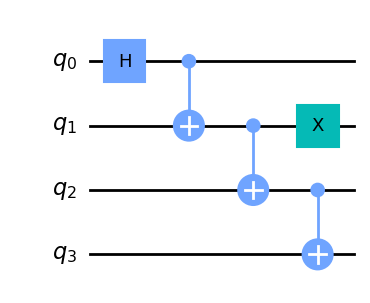

OPENQASM 2.0;
include "qelib1.inc";
qreg q[4];
h q[0];
cx q[0],q[1];
cx q[1],q[2];
cx q[2],q[3];
x q[1];



In [19]:
circuit = QuantumCircuit(4)
circuit.h(0)
circuit.cx(0, 1)
circuit.cx(1,2)
circuit.cx(2,3)
circuit.x(1)

display(circuit.draw('mpl'))

answer = serialize_answer([[3], [4], [2], [2], [4], [2], [4], [1], [2], [1], [3], [3], [2], [2], circuit.qasm()])
print(circuit.qasm())

In [20]:
a = json.loads(answer)

In [21]:
qc = QuantumCircuit.from_qasm_str(a[14])

In [22]:
Statevector(qc)

Statevector([0.        +0.j, 0.        +0.j, 0.70710678+0.j,
             0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.70710678+0.j, 0.        +0.j,
             0.        +0.j],
            dims=(2, 2, 2, 2))


In [23]:
answer = {"1": 23}
print(answer["2"])

KeyError: '2'

## Challenge 3

In [24]:
from qiskit import QuantumCircuit
from qiskit.providers.aer import AerSimulator


## Write your code below here ##
qc = QuantumCircuit(4,4)
qc.measure([0,1,2,3],[0,1,2,3])

serialize_answer(qc.qasm())

'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[4];\ncreg c[4];\nmeasure q[0] -> c[0];\nmeasure q[1] -> c[1];\nmeasure q[2] -> c[2];\nmeasure q[3] -> c[3];\n'

## Challenge 4

In [25]:
serialize_answer(True)

'True'

In [26]:
serialize_answer([0, 1, 1]) == '[0, 1, 1]'

True

## Challenge 5

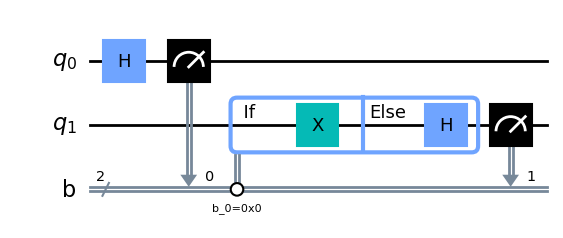

In [27]:
from qiskit import qasm3
qr = QuantumRegister(2, name = "q")
cr = ClassicalRegister(2, name = "b")
qc = QuantumCircuit(qr, cr)

q0, q1 = qr
b0, b1 = cr

qc.h(q0)
qc.measure(q0, b0)


## Write your code below this line ## 

with qc.if_test((b0, 0)) as else_:
    qc.x(q1)
with else_:
    qc.h(q1)

## Do not change the code below this line ##


qc.measure(q1, b1)
qc.draw(output="mpl", idle_wires=False)

In [28]:
print(qasm3.dumps(qc))

OPENQASM 3;
include "stdgates.inc";
bit[2] b;
qubit[2] q;
h q[0];
b[0] = measure q[0];
if (!b[0]) {
  x q[1];
} else {
  h q[1];
}
b[1] = measure q[1];



In [29]:
qasm3.loads(qasm3.dumps(qc))

In [30]:
from qiskit import assemble
qc = assemble(QuantumCircuit(1,1))
qc.to_dict()

{'qobj_id': '4611373d-07f0-4e92-9201-3d918df694ac',
 'header': {},
 'config': {'shots': 1024,
  'memory': False,
  'parameter_binds': [],
  'meas_level': <MeasLevel.CLASSIFIED: 2>,
  'init_qubits': True,
  'parametric_pulses': [],
  'memory_slots': 1,
  'n_qubits': 1},
 'schema_version': '1.3.0',
 'type': 'QASM',
 'experiments': [{'config': {'n_qubits': 1, 'memory_slots': 1},
   'header': {'qubit_labels': [['q', 0]],
    'n_qubits': 1,
    'qreg_sizes': [['q', 1]],
    'clbit_labels': [['c', 0]],
    'memory_slots': 1,
    'creg_sizes': [['c', 1]],
    'name': 'circuit-140',
    'global_phase': 0.0,
    'metadata': {}},
   'instructions': []}]}

## Challenge 6

In [31]:
qubit_C = QuantumRegister(1, name="qubit C")
qubit_A = QuantumRegister(1, name="qubit A")
qubit_B = QuantumRegister(1, name="qubit B")
mC = ClassicalRegister(1, name="mC")
mA = ClassicalRegister(1, name="mA")
base = QuantumCircuit(qubit_C, qubit_A, qubit_B, mC, mA)

def change_basis(
    circuit: QuantumCircuit,
    mC: QuantumRegister,
    mA: QuantumRegister
) -> None:
    
    ## Write your code below this line, making sure it's indented to where this comment begins from ## 
    
    circuit.cx(0,1)
    circuit.h(0)
    circuit.measure([0,1],[0,1])
    
    ## Do not change the code below this line ##
answer2 = base.copy_empty_like()
change_basis(answer2, mC, mA)

print(qasm3.dumps(answer2))

OPENQASM 3;
include "stdgates.inc";
bit[1] mC;
bit[1] mA;
qubit[1] _qubit_C;
qubit[1] _qubit_A;
qubit[1] _qubit_B;
cx _qubit_C[0], _qubit_A[0];
h _qubit_C[0];
mC[0] = measure _qubit_C[0];
mA[0] = measure _qubit_A[0];



In [32]:
serialize_answer(qasm3.dumps(answer2))

'OPENQASM 3;\ninclude "stdgates.inc";\nbit[1] mC;\nbit[1] mA;\nqubit[1] _qubit_C;\nqubit[1] _qubit_A;\nqubit[1] _qubit_B;\ncx _qubit_C[0], _qubit_A[0];\nh _qubit_C[0];\nmC[0] = measure _qubit_C[0];\nmA[0] = measure _qubit_A[0];\n'

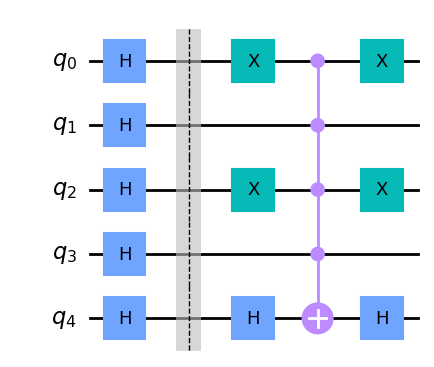

In [33]:
q = QuantumRegister(5, name = "q")
base = QuantumCircuit(q)
base.draw("mpl")

def state_preparation(circuit: QuantumCircuit) -> None:
    
    ## Write your code below this line, making sure it's indented to where this comment begins from ## 
    
    circuit.h([0,1,2,3,4])

    ## Do not change the code below this line ##
    
def cnz(n: int) -> QuantumCircuit:
    circuit = QuantumCircuit(n)
    circuit.h(n-1)
    circuit.mcx([i for i in range(n-1)], n-1)
    circuit.h(n-1)
    return circuit

def oracle(circuit: QuantumCircuit) -> None:
    """Grover's oracle for |11010>"""
    
    ## Write your code below this line, making sure it's indented to where this comment begins from ## 
    
    circuit.x([0,2])
    circuit.compose(cnz(5), inplace=True)
    circuit.x([0,2])

    ## Do not change the code below this line ##
    
qc = base.copy_empty_like()
state_preparation(qc)
qc.barrier()
oracle(qc)
qc.draw('mpl', cregbundle=False)

In [34]:
serialize_answer(qc.qasm())

'OPENQASM 2.0;\ninclude "qelib1.inc";\ngate rcccx q0,q1,q2,q3 { u2(0,pi) q3; u1(pi/4) q3; cx q2,q3; u1(-pi/4) q3; u2(0,pi) q3; cx q0,q3; u1(pi/4) q3; cx q1,q3; u1(-pi/4) q3; cx q0,q3; u1(pi/4) q3; cx q1,q3; u1(-pi/4) q3; u2(0,pi) q3; u1(pi/4) q3; cx q2,q3; u1(-pi/4) q3; u2(0,pi) q3; }\ngate rcccx_dg q0,q1,q2,q3 { u2(-2*pi,pi) q3; u1(pi/4) q3; cx q2,q3; u1(-pi/4) q3; u2(-2*pi,pi) q3; u1(pi/4) q3; cx q1,q3; u1(-pi/4) q3; cx q0,q3; u1(pi/4) q3; cx q1,q3; u1(-pi/4) q3; cx q0,q3; u2(-2*pi,pi) q3; u1(pi/4) q3; cx q2,q3; u1(-pi/4) q3; u2(-2*pi,pi) q3; }\ngate mcx q0,q1,q2,q3,q4 { h q4; cu1(pi/2) q3,q4; h q4; rcccx q0,q1,q2,q3; h q4; cu1(-pi/2) q3,q4; h q4; rcccx_dg q0,q1,q2,q3; c3sqrtx q0,q1,q2,q4; }\nqreg q[5];\nh q[0];\nh q[1];\nh q[2];\nh q[3];\nh q[4];\nbarrier q[0],q[1],q[2],q[3],q[4];\nx q[0];\nx q[2];\nh q[4];\nmcx q[0],q[1],q[2],q[3],q[4];\nh q[4];\nx q[0];\nx q[2];\n'

In [35]:
json.loads(serialize_answer(4))

4

## Challenge 9

In [36]:
import networkx as nx
import numpy as np
import plotly.graph_objects as go
import matplotlib as mpl
import pandas as pd
from IPython.display import clear_output
from plotly.subplots import make_subplots
from matplotlib import pyplot as plt
from qiskit import Aer
from qiskit import QuantumCircuit
from qiskit.visualization import plot_state_city
from qiskit.algorithms.optimizers import COBYLA, SLSQP, ADAM
from time import time
from copy import copy
from typing import List

In [37]:
from ipywidgets import Output, HTML
from ipycytoscape import CytoscapeWidget
from IPython.display import display, clear_output
from networkx.algorithms.shortest_paths import unweighted
from plotly.subplots import make_subplots
from plotly import graph_objects as go
from copy import deepcopy
from typing import Optional, Tuple
import pandas as pd
import numpy as np
import networkx as nx


def weighted_graph(graph: nx.Graph, weight_range: Tuple[float,float]=(-1,1), integer_weights: bool = True, seed: Optional[int] = None) -> nx.Graph:
    '''
    Takes an unweighted input graph and returns a weighted graph where the weights are uniformly sampled at random
    Args:
        graph: Unweighted graph to add edge weights to
        weight_range: Range of weights to sample from
        integer_weights: Specifies whether weights should be integer (True) or float (False)
        seed: A seed for the random number generator
    Returns:
        The weighted graph
    '''
    if seed is not None:
        np.random.seed(seed)

    weighted_graph = deepcopy(graph)
    for edge in weighted_graph.edges:
        if integer_weights:
            weighted_graph[edge[0]][edge[1]]['weight'] = np.random.randint(int(weight_range[0]), int(weight_range[1]))
        else:
            weighted_graph[edge[0]][edge[1]]['weight'] = np.random.uniform(weight_range[0], weight_range[1])
    
    return weighted_graph

def display_maxcut_widget(graph: nx.Graph):
    '''
    Displays a MaxCut widget for a networkx graph
    Args:
        graph: The graph to display
    '''

    #Initialize Out widget for displaying cut value and cytoscape widget to display graph
    out= Output()
    cyto = CytoscapeWidget()
    cyto.graph.add_graph_from_networkx(graph)
    selected_ids = []

    def update(node):
        '''
        Update method to be called when anode is selected
        Args:
            node: Selected node from cytoscape widget
        '''

        #Update selected node IDs
        node_id = int(node['data']['id'])
        if node_id in selected_ids:
            selected_ids.remove(node_id)
        else:
            selected_ids.append(node_id)

        #Update style of graph accordingly
        #Base style to be applied to non-selected nodes and edges
        style = [
            {
                'selector': 'node',
                'css': {
                    'background-color': '#33B1FF'
                }
            },
            {
                'selector': 'edge',
                'css': {
                    'line-color': '#DFDFDF',
                    'label': 'data(weight)'
                }
            }
        ]

        #Update style for selected nodes
        for id in selected_ids:
            style.append(
                {
                    'selector': f'node[id = "{id}"]',
                    'css': {
                        'background-color':  '#002C9C'

                    }
                }
            )

        #Calculate cut weight and update style for edges in cut
        weight = 0
        for id_0 in range(graph.number_of_nodes()):
            for id_1 in range(graph.number_of_nodes()):
                if (id_0 in selected_ids and not id_1 in selected_ids) or (id_1 in selected_ids and not id_0 in selected_ids):
                    #Update edge style
                    style = style + [
                        {
                            'selector': f'edge[target = "{id_0}"][source = "{id_1}"]',
                            'css': {
                                'line-color': '#D12765'

                            }
                        },
                        {
                            'selector': f'edge[target = "{id_1}"][source = "{id_0}"]',
                            'css': {
                                'line-color': '#D12765'
                            }
                        }
                    ]
                    
                    #Update weight
                    try:
                        weight += 0.5*graph[id_0][id_1].get('weight',1.0)
                    except KeyError:
                        pass
        

        cyto.set_style(style)

        #Clear output and display new cut value
        with out:
            clear_output()
            display(HTML(value=f' < p style="font-size:20px"> Cut weight: {weight}  < /p>'))

    #Bind update method to click event and set base style
    cyto.on('node','click',update)
    cyto.on('edge','click',update)
    cyto.set_style([{
                        'selector': 'node',
                        'css': {
                            'background-color': '#33B1FF'
                        }
                    },
                    {
                        'selector': 'edge',
                        'css': {
                            'line-color': '#DFDFDF',
                            'label': 'data(weight)'
                        }
                    }
    ])

    #Display widget
    display(cyto)
    display(out)

def QAOA_widget(landscape_file, ax = None, xaxis_range = None, yaxis_range = None, trajectory={'beta_0': [], 'gamma_0':[], 'energy': []}, samples = None):
    '''
    Returns a figure showing 
        1) the energy landscape of a p=1 QAOA instance with the trajectory of an optimization process
        2) A line plot describing the evolution of the measured energy
        3) A bar plot of the final measurement samples 
    Args:
        landscape_file: csv file contanining landscape data
        ax: axes to plot on
        x_axis_range: x axis range of the QAOA landscape plot
        y_axis_range: y axis range of the QAOA landscape plot
        trajectory: Optimization trajectory given as a dictionary of lists for keys 'beta_0','gamma_0' and 'energy'
        samples: The samples of the final state
    Returns:
        Figure displaying QAOA instance and optimization process
    '''
    #Read data from landscape file
    df = pd.read_csv(landscape_file)
    #The landscape files contain negative energy values, so we need to adjust the sign
    df['energy'] = -df['energy']
    df = df.pivot(index='beta_0', columns='gamma_0', values='energy')
    matrix = df.to_numpy()
    beta_values = df.index.tolist()
    gamma_values = df.columns.tolist()

    #Create plot of energy surface
    surface_plot = go.Surface(
        x=gamma_values, 
        y=beta_values,
        z=matrix,
        coloraxis = 'coloraxis'
    )

    #Create trace for optimizer trajectory on energy landscape
    scatter_plot = go.Scatter3d(
        x=trajectory['gamma_0'], 
        y=trajectory['beta_0'], 
        #We add a small offset to the height of the trajectory points to make the trajectory more visible
        z=[ x + 0.05 for x in trajectory['energy']],
        marker=dict(
            size=4,
            color=trajectory['energy'],
            colorscale = 'GnBu'
        ),
        line=dict(
            color='darkblue',
            width=2
        )
    )  

    #Create line plot for plotting energy evolution
    line_plot = go.Scatter(
        x=list(range(len(trajectory['energy']))), 
        y=trajectory['energy'], 
        mode='lines+markers', 
        marker=dict(color=trajectory['energy'], coloraxis="coloraxis", size = 5),
        line = dict(color = 'darkblue')
    )

    #Create bar plot of final samples
    if samples is not None:
        samples = sorted(samples, key = lambda x: x.probability)
        probabilities = [sample.probability for sample in samples]
        values = [sample.fval for sample in samples]
        bitstrings = [''.join([str(int(i)) for i in sample.x]) for sample in samples]
        sample_plot = go.Bar(x = bitstrings, y = probabilities, marker=dict(color=values, coloraxis="coloraxis"))
    else:
        sample_plot = []

    #Create figure combining all plots into one
    fig = make_subplots(rows = 1, cols = 3, subplot_titles = ['QAOA Energy Landscape', 'Energy value', 'Final Samples'], column_widths=[0.5, 0.25,0.25], specs=[[{"type": "scatter3d"}, {"type": "scatter"}, {"type": "bar"}]])
    fig.update_layout(width=1800,height=600, coloraxis=dict(colorscale='plasma'), showlegend=False)
    fig.add_trace(surface_plot, row=1, col=1)
    fig.add_trace(scatter_plot, row=1, col=1)
    fig.add_trace(sample_plot, row=1, col=3)
    fig.add_trace(line_plot, row=1, col=2)
    fig.update_scenes(
        xaxis = 
        {
            'range': [0,4*np.pi]
        },
        yaxis =
        {
            'range': [0,np.pi]
        },
        xaxis_title =  '\u03b3',
        yaxis_title =  '\u03b2',
        aspectratio = 
        {
            'x':3,
            'y':1,
            'z':1
        },
        row = 1,
        col=1
    )
    fig.update_xaxes(title_text="Number of iterations", row=1, col=2)
    fig.update_xaxes(type="category", row=1, col=3)
    fig.update_yaxes(title_text="Measured Energy", row=1, col=2)
    fig.update_yaxes(title_text="Probability", row=1, col=3)

    return fig

unweighted_graphs = {
    'barbell': nx.barbell_graph(4,0),
    'circular_small': nx.cycle_graph(5),
    'circular_large': nx.cycle_graph(10),
    'fully_connected_small': nx.complete_graph(5),
    'fully_connected_large': nx.complete_graph(10)
}

graphs = {}
for graph_name, graph in unweighted_graphs.items():
    graphs[graph_name + '_unweighted'] = graph
    graphs[graph_name + '_float(-1_1)'] = weighted_graph(graph = graph, weight_range = (-1,1), integer_weights = False, seed = 42)
    graphs[graph_name + '_int(-5_5)'] =  weighted_graph(graph = graph, weight_range = (-5,5), integer_weights = True, seed = 42)


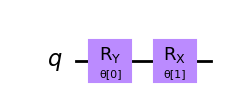

In [38]:
from qiskit.circuit import Parameter, ParameterVector
#Parameter이 간단한 string으로 초기화됩니다
parameter_0 = Parameter('θ[0]')
parameter_1 = Parameter('θ[1]')
circuit1 = QuantumCircuit(1)
#초기화된 Parameter을 Rx와 Ry 게이트의 회전 각도 변수(rotation angle argument)로 넣을 수 있습니다
circuit1.ry(theta = parameter_0, qubit = 0)
circuit1.rx(theta = parameter_1, qubit = 0)
circuit1.draw('mpl')

In [39]:
print(json.loads(serialize_answer(circuit1)))

{'qc': "\x80\x04\x95\x89\x05\x00\x00\x00\x00\x00\x00\x8c\x1dqiskit.circuit.quantumcircuit\x94\x8c\x0eQuantumCircuit\x94\x93\x94)\x81\x94}\x94(\x8c\n_base_name\x94\x8c\x07circuit\x94\x8c\x04name\x94\x8c\x0bcircuit-147\x94\x8c\x05_data\x94]\x94(\x8c!qiskit.circuit.quantumcircuitdata\x94\x8c\x12CircuitInstruction\x94\x93\x94)\x81\x94N}\x94(\x8c\toperation\x94\x8c(qiskit.circuit.library.standard_gates.ry\x94\x8c\x06RYGate\x94\x93\x94)\x81\x94}\x94(\x8c\x0b_definition\x94N\x8c\x05_name\x94\x8c\x02ry\x94\x8c\x0b_num_qubits\x94K\x01\x8c\x0b_num_clbits\x94K\x00\x8c\x07_params\x94]\x94\x8c\x18qiskit.circuit.parameter\x94\x8c\tParameter\x94\x93\x94\x8c\x05Î¸[0]\x94\x8c\x04uuid\x94\x8c\x04UUID\x94\x93\x94)\x81\x94}\x94\x8c\x03int\x94\x8a\x111\x9f{YmÀ±\x87ÊHã\x1d?\x0b;\x96\x00sb\x86\x94\x81\x94}\x94h\x07h sba\x8c\x06_label\x94N\x8c\tcondition\x94N\x8c\t_duration\x94N\x8c\x05_unit\x94\x8c\x02dt\x94ub\x8c\x06qubits\x94\x8c\x1eqiskit.circuit.quantumregister\x94\x8c\x05Qubit\x94\x93\x94)\x81\x94N}\x94

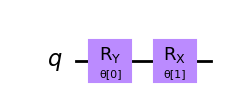

In [40]:
from qiskit.circuit import Parameter, ParameterVector
#Parameter이 간단한 string으로 초기화됩니다
parameter_0 = Parameter('θ[0]')
parameter_1 = Parameter('θ[1]')
circuit2 = QuantumCircuit(1)
#초기화된 Parameter을 Rx와 Ry 게이트의 회전 각도 변수(rotation angle argument)로 넣을 수 있습니다
circuit2.ry(theta = parameter_0, qubit = 0)
circuit2.rx(theta = parameter_1, qubit = 0)
circuit2.draw('mpl')

In [41]:
qasm3.dumps(circuit1) == qasm3.dumps(circuit2)

True

In [42]:
circuit1 == circuit2

False

In [43]:
from qiskit_optimization import QuadraticProgram
quadratic_program = QuadraticProgram('sample_problem')
print(quadratic_program.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: sample_problem

Minimize
 obj:
Subject To

Bounds
End



In [44]:
graph = nx.Graph()
#Add nodes and edges
graph.add_nodes_from(np.arange(0,6,1))
edges = [(0,1,2.0),(0,2,3.0),(0,3,2.0),(0,4,4.0),(0,5,1.0),(1,2,4.0),(1,3,1.0),(1,4,1.0),(1,5,3.0),(2,4,2.0),(2,5,3.0),(3,4,5.0),(3,5,1.0)]
graph.add_weighted_edges_from(edges)
graphs['custom'] = graph
#Display widget
display_maxcut_widget(graphs['custom'])

CytoscapeWidget(cytoscape_layout={'name': 'cola'}, cytoscape_style=[{'selector': 'node', 'css': {'background-c…

Output()

In [45]:
def quadratic_program_from_graph(graph: nx.Graph) -> QuadraticProgram:
    """Constructs a quadratic program from a given graph for a MaxCut problem instance.
    Args:
        graph: Underlying graph of the problem.
    Returns:
        QuadraticProgram
    """
    #Get weight matrix of graph
    weight_matrix = nx.adjacency_matrix(graph)
    shape = weight_matrix.shape
    size = shape[0]
    #Build qubo matrix Q from weight matrix W
    qubo_matrix = np.zeros((size, size))
    qubo_vector = np.zeros(size)
    for i in range(size):
        for j in range(size):
            qubo_matrix[i, j] -= weight_matrix[i, j]
    for i in range(size):
        for j in range(size):
            qubo_vector[i] += weight_matrix[i,j]


    quadratic_program = QuadraticProgram('quadratic_program')
###############INSERT YOUR CODE HERE#####################
    for i in range(size):
        quadratic_program.binary_var(name = 'x_'+str(i))
    quadratic_program.maximize(quadratic = qubo_matrix, linear = qubo_vector)
    
########################################################
    return quadratic_program

In [46]:
quadratic_program = quadratic_program_from_graph(graphs['custom'])

In [47]:
serialize_answer(str(quadratic_program))

"maximize -4*x_0*x_1 - 6*x_0*x_2 - 4*x_0*x_3 - 8*x_0*x_4 - 2*x_0*x_5 - 8*x_1*x_2 - 2*x_1*x_3 - 2*x_1*x_4 - 6*x_1*x_5 - 4*x_2*x_4 - 6*x_2*x_5 - 10*x_3*x_4 - 2*x_3*x_5 + 12*x_0 + 11*x_1 + 12*x_2 + 9*x_3 + 12*x_4 + 8*x_5 (6 variables, 0 constraints, 'quadratic_program')"

In [48]:
json.loads(serialize_answer([0, 0, 0, 0, 0, 0]))

[0, 0, 0, 0, 0, 0]

In [56]:
def qaoa_circuit(qubo: QuadraticProgram, p: int = 1):
    """
    Given a QUBO instance and the number of layers p, constructs the corresponding parameterized QAOA circuit with p layers.
    Args:
        qubo: The quadratic program instance
        p: The number of layers in the QAOA circuit
    Returns:
        The parameterized QAOA circuit
    """
    size = len(qubo.variables)
    qubo_matrix = qubo.objective.quadratic.to_array(symmetric=True)
    qubo_linearity = qubo.objective.linear.to_array()
    print(qubo_matrix)

    #Prepare the quantum and classical registers
    qaoa_circuit = QuantumCircuit(size,size)
    #Apply the initial layer of Hadamard gates to all qubits
    qaoa_circuit.h(range(size))

    #Create the parameters to be used in the circuit
    gammas = ParameterVector('gamma', p)
    betas = ParameterVector('beta', p)

    #Outer loop to create each layer
    for i in range(p):

        #################INSERT YOUR CODE HERE##############################
        #비용 레이어에서 R_Z 회전 게이트를 적용하세요
        for j in range(size):
            Q_sum = 0
            for k in range(size):
                Q_sum += qubo_matrix[j,k]
            qaoa_circuit.rz((qubo_linearity[j]+Q_sum)*gammas[i], j)
        
        #비용 레이어에서 얽힘 큐비트 회전을 위해 R_ZZ 회전 게이트를 적용하세요
        for j in range(size):
            for k in range(size):
                if j!=k:
                    qaoa_circuit.rzz(qubo_matrix[j,k]*0.5*gammas[i], j, k)
        
        #모든 큐비트에 2*beta_i의 각도로 X 회전을 적용하세요
        for j in range(size):
            qaoa_circuit.rx(2*betas[i], j)
        ####################################################################
            
    return qaoa_circuit

In [57]:
quadratic_program = quadratic_program_from_graph(graphs['custom'])
custom_circuit = qaoa_circuit(qubo = quadratic_program)

[[ 0. -2. -3. -2. -4. -1.]
 [-2.  0. -4. -1. -1. -3.]
 [-3. -4.  0.  0. -2. -3.]
 [-2. -1.  0.  0. -5. -1.]
 [-4. -1. -2. -5.  0.  0.]
 [-1. -3. -3. -1.  0.  0.]]


In [58]:
test = custom_circuit.assign_parameters(parameters=[1.0]*len(custom_circuit.parameters))

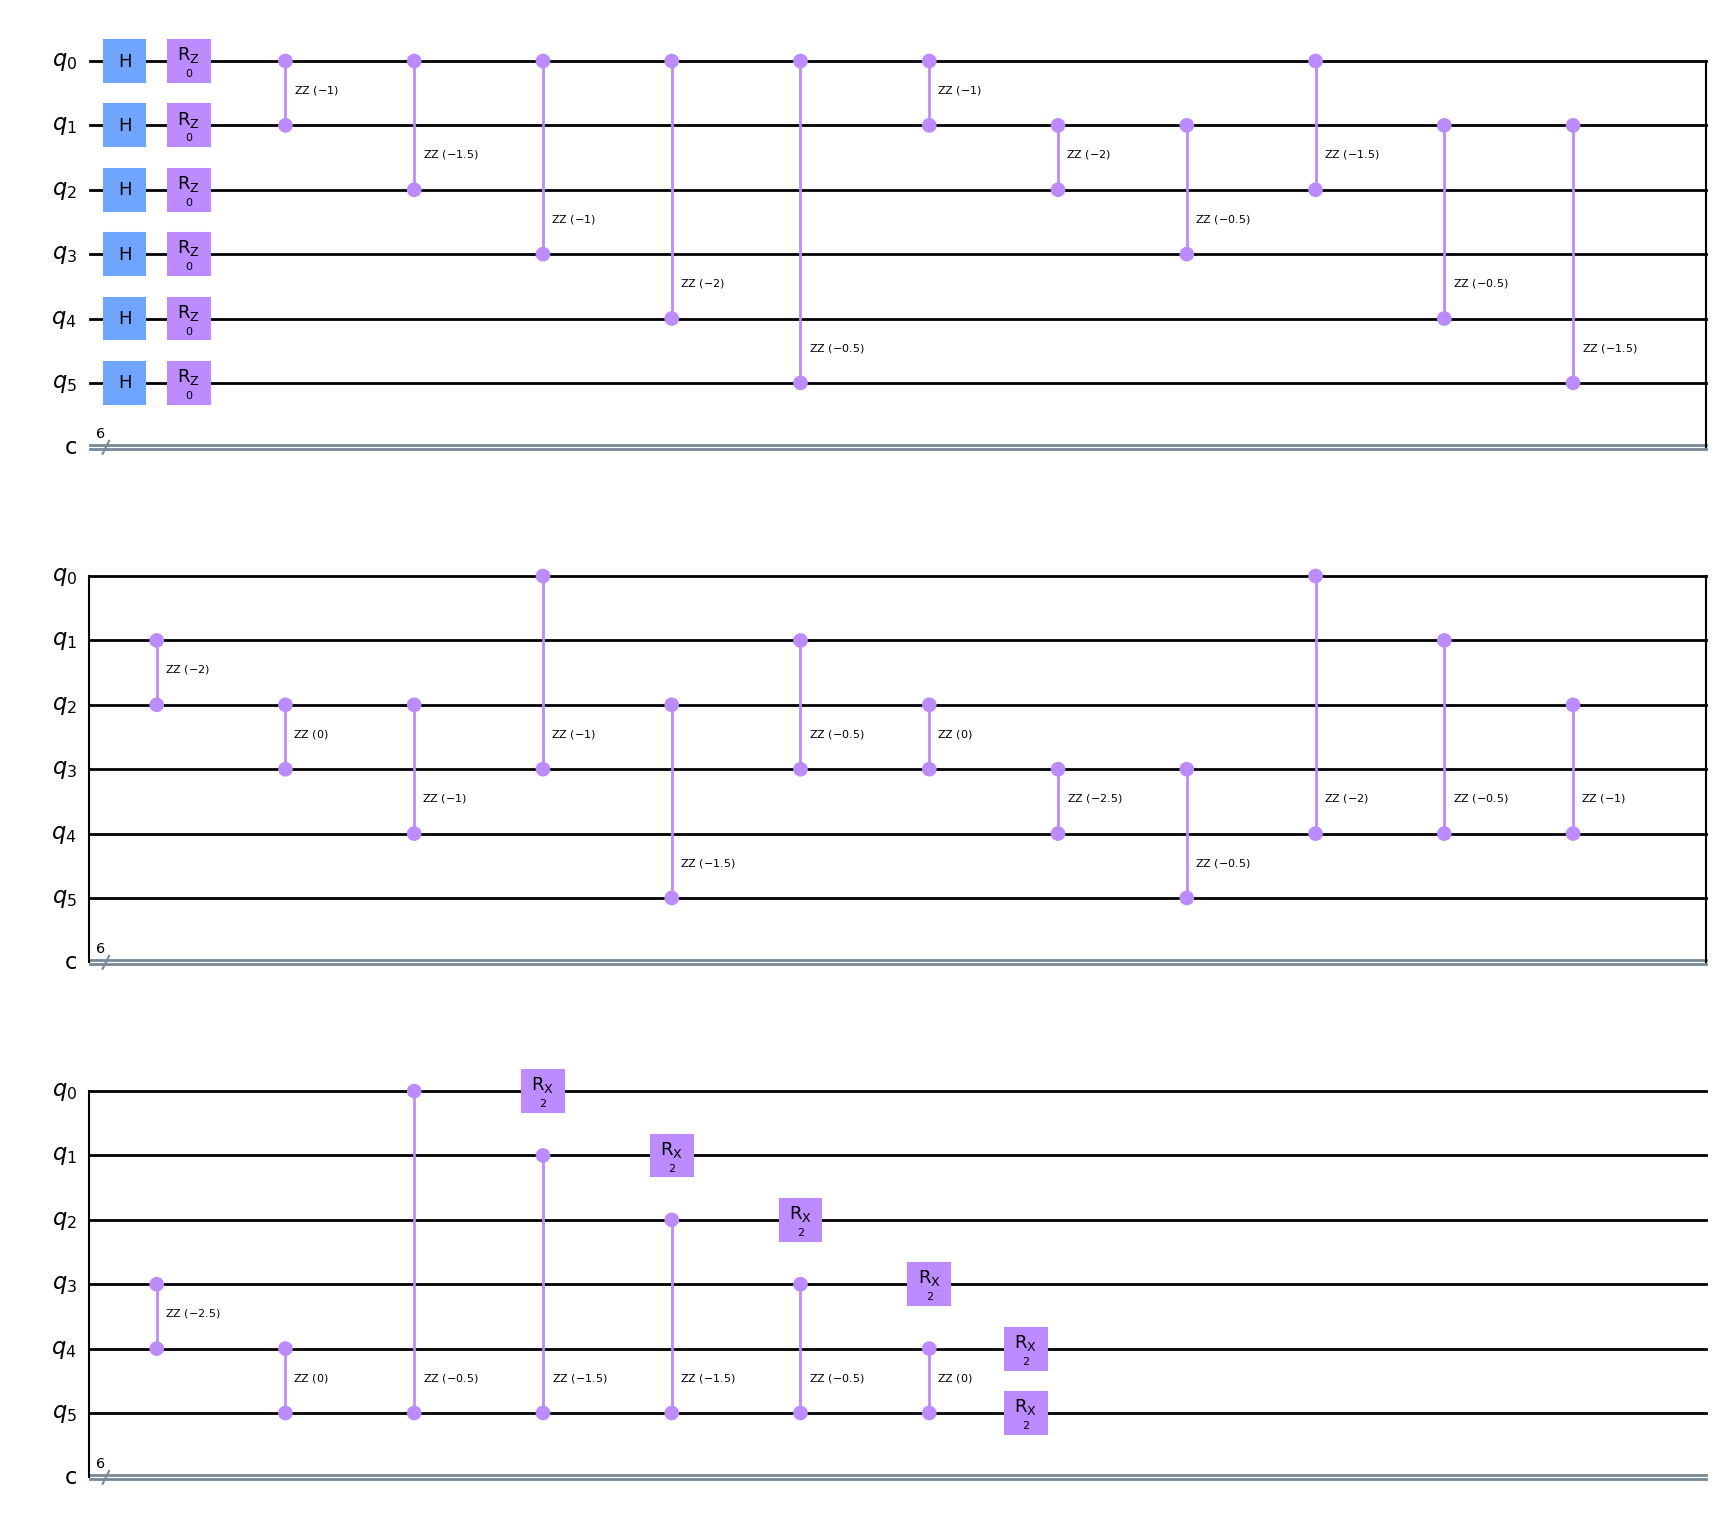

In [52]:
test.draw('mpl')

In [53]:
Statevector(test)

Statevector([ 0.01642343+0.1162963j , -0.15729712+0.01466156j,
              0.00378228+0.09849813j,  0.02509607+0.0238105j ,
              0.14722566+0.03625675j, -0.19631382+0.13591901j,
             -0.10098406-0.09968545j, -0.01938766-0.01185747j,
             -0.12299726-0.14491039j,  0.00133437-0.05100495j,
             -0.0105355 -0.03292546j, -0.03551066+0.03746002j,
              0.06116107-0.07227536j,  0.00556622-0.0068689j ,
             -0.02371316-0.12890153j,  0.05038829-0.13606232j,
              0.08791714-0.01614208j, -0.11726462+0.05171065j,
             -0.03571204-0.03971669j,  0.16997357-0.18490429j,
              0.0152319 +0.08472621j,  0.00140389+0.00531654j,
              0.06315405-0.19247938j,  0.13152371-0.07707045j,
             -0.12587265+0.11784468j, -0.02529827-0.09972611j,
             -0.09744774+0.01450246j,  0.05563722-0.02446786j,
              0.02708904+0.05326489j, -0.04173254+0.04632897j,
              0.10211393+0.14251563j,  0.07431616+0.017

In [54]:
test.qasm()

'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[6];\ncreg c[6];\nh q[0];\nh q[1];\nh q[2];\nh q[3];\nh q[4];\nh q[5];\nrz(0) q[0];\nrz(0) q[1];\nrz(0) q[2];\nrz(0) q[3];\nrz(0) q[4];\nrz(0) q[5];\nrzz(-1.0) q[0],q[1];\nrzz(-1.5) q[0],q[2];\nrzz(-1.0) q[0],q[3];\nrzz(-2.0) q[0],q[4];\nrzz(-0.5) q[0],q[5];\nrzz(-1.0) q[1],q[0];\nrzz(-2.0) q[1],q[2];\nrzz(-0.5) q[1],q[3];\nrzz(-0.5) q[1],q[4];\nrzz(-1.5) q[1],q[5];\nrzz(-1.5) q[2],q[0];\nrzz(-2.0) q[2],q[1];\nrzz(0) q[2],q[3];\nrzz(-1.0) q[2],q[4];\nrzz(-1.5) q[2],q[5];\nrzz(-1.0) q[3],q[0];\nrzz(-0.5) q[3],q[1];\nrzz(0) q[3],q[2];\nrzz(-2.5) q[3],q[4];\nrzz(-0.5) q[3],q[5];\nrzz(-2.0) q[4],q[0];\nrzz(-0.5) q[4],q[1];\nrzz(-1.0) q[4],q[2];\nrzz(-2.5) q[4],q[3];\nrzz(0) q[4],q[5];\nrzz(-0.5) q[5],q[0];\nrzz(-1.5) q[5],q[1];\nrzz(-1.5) q[5],q[2];\nrzz(-0.5) q[5],q[3];\nrzz(0) q[5],q[4];\nrx(2.0) q[0];\nrx(2.0) q[1];\nrx(2.0) q[2];\nrx(2.0) q[3];\nrx(2.0) q[4];\nrx(2.0) q[5];\n'

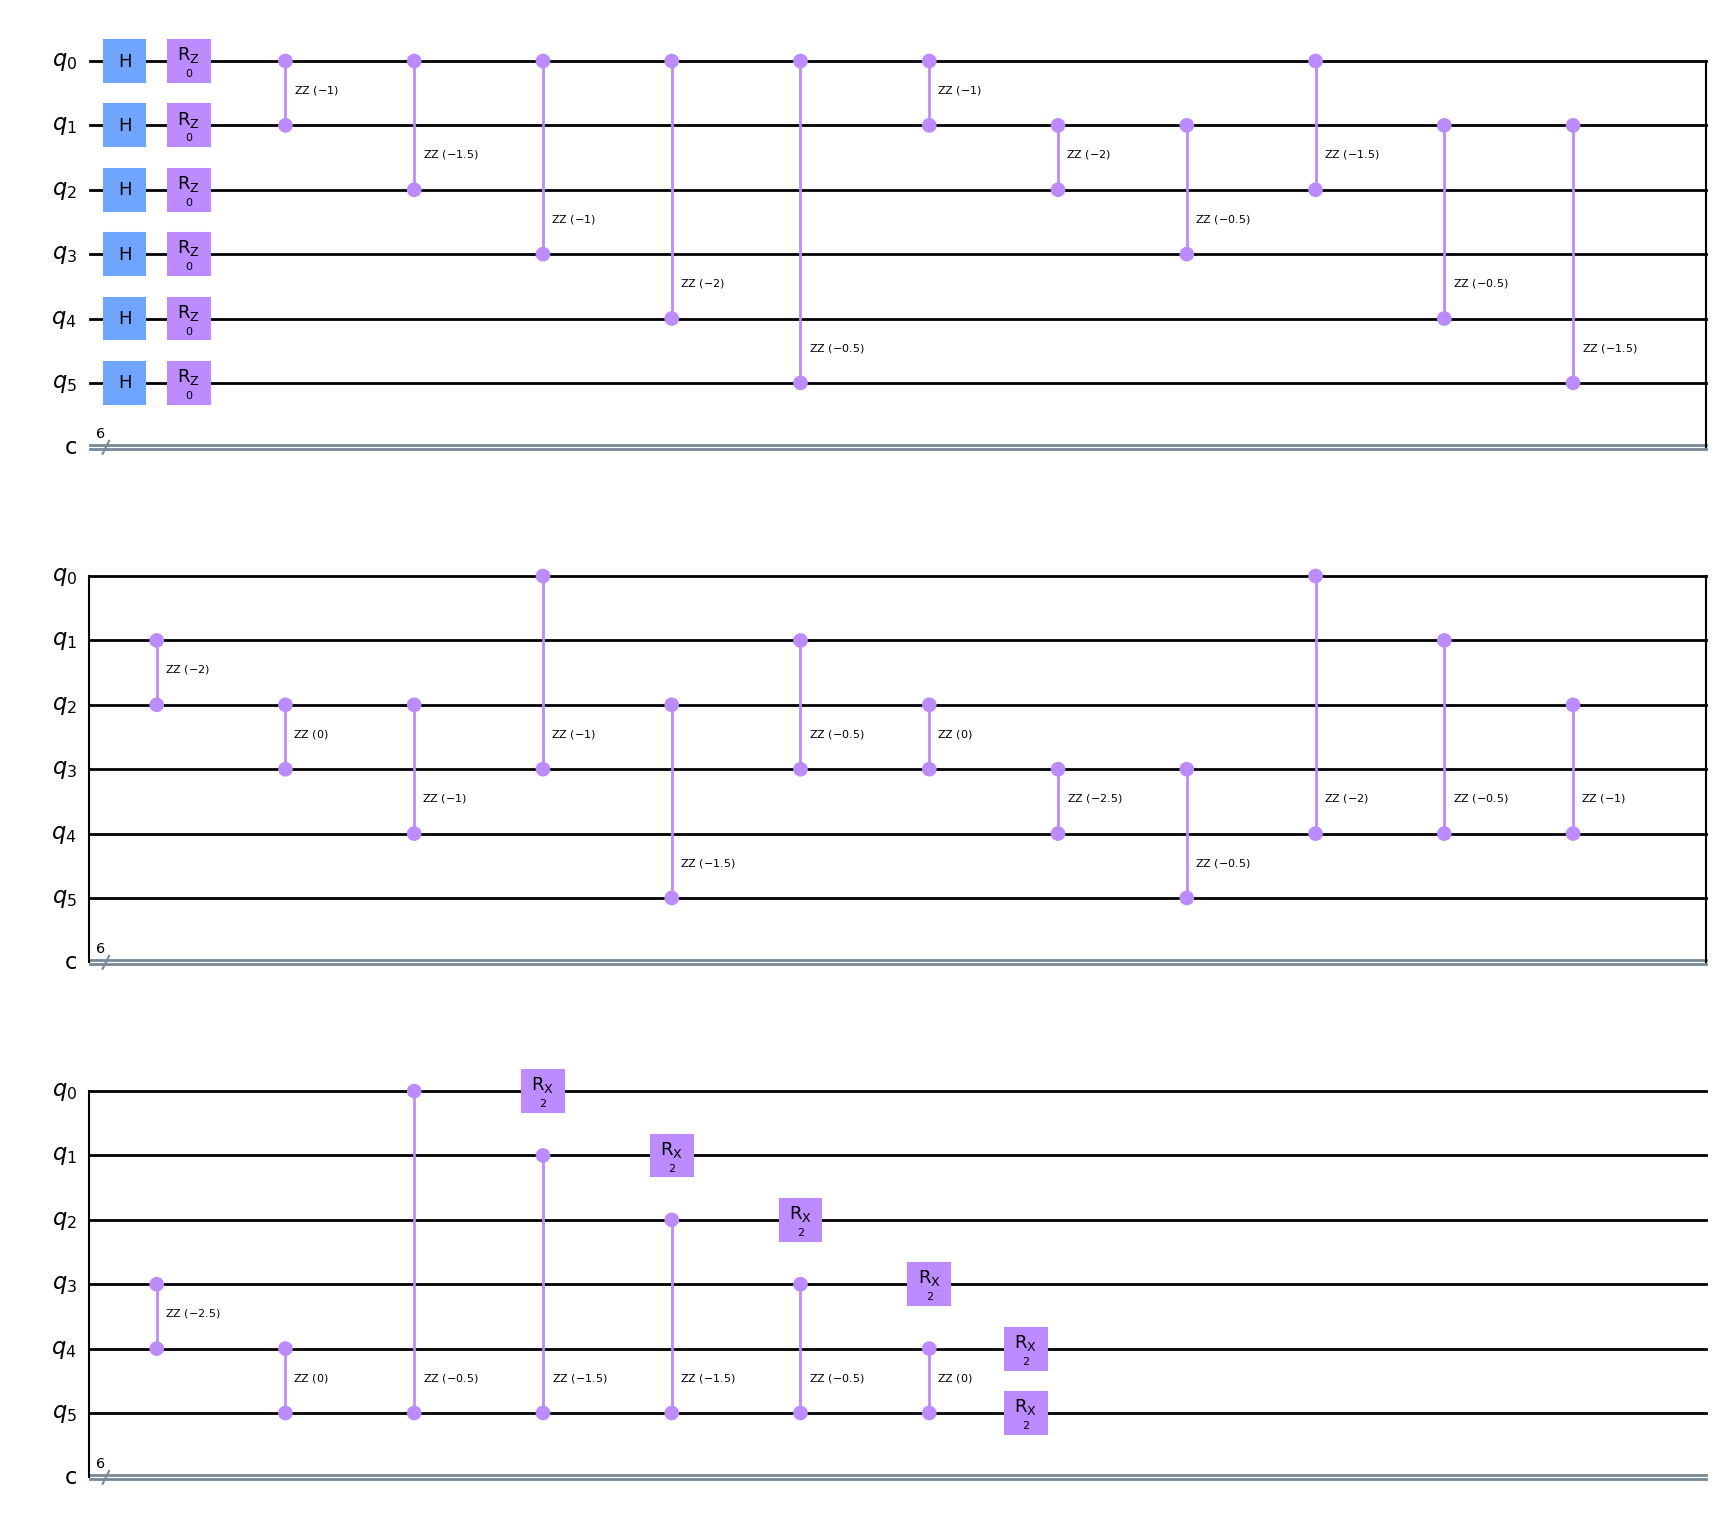

In [55]:
QuantumCircuit.from_qasm_str(test.qasm()).draw('mpl')

## Challenge 10

In [76]:
# 고전적인 간단한 디코더를 만들어 봅시다
backend = Aer.get_backend('unitary_simulator')
def create_decoder(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:
    # 하나의 비트가 첫 3개의 큐비트로 인코딩되고 4번째 큐비트에 디코딩되도록 합니다
    # 첫 3개 큐비트의 값은 변하지 않습니다

    qc = QuantumCircuit(qr, cr)
    q0, q1, q2, q3 = qr
    (c0,) = cr

############## Insert code here ##############
    qc.ccx(q0, q1, q3)
    qc.ccx(q1, q2, q3)
    qc.ccx(q0, q2, q3)
##############################################

    return qc
qr = QuantumRegister(4, name = 'q')
cr = ClassicalRegister(1, name = 'c')

from qiskit import execute
answer = create_decoder(qr, cr)
backend = Aer.get_backend('unitary_simulator')

result = execute(answer, backend).result().get_unitary()
result.data

array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.

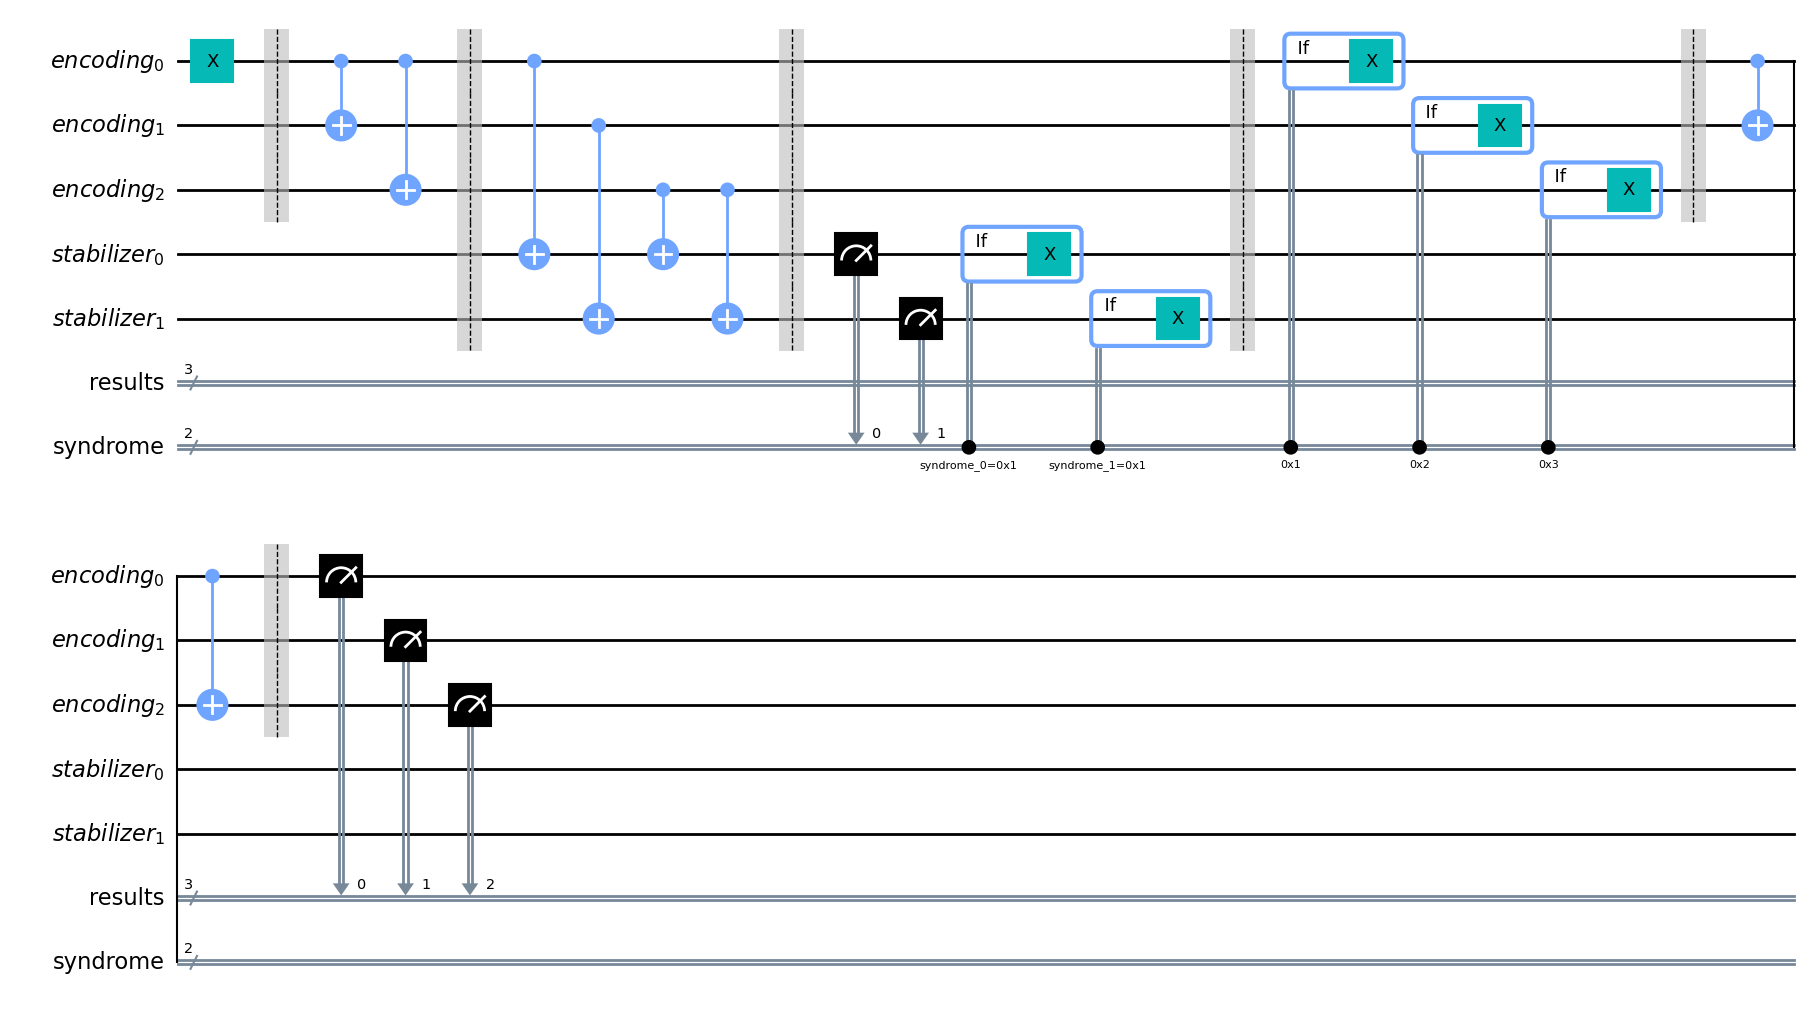

In [78]:
# 실험을 위한 기초 회로를 셋업합니다
encoding = QuantumRegister(3, name = "encoding")
stabilizer = QuantumRegister(2, name = "stabilizer")

encoding_q0, encoding_q1, encoding_q2 = encoding
stabilizer_q0, stabilizer_q1 = stabilizer

# 인코딩의 결과
results = ClassicalRegister(3, name = "results")

result_b0, result_b1, result_b2 = results

# 신드롬을 측정합니다
syndrome = ClassicalRegister(2, name = "syndrome")

syndrome_b0, syndrome_b1 = syndrome

# 인코딩된 실제 큐비트
state = encoding[0]

# state를 인코딩하기 위해 사용된 ancillas
ancillas = encoding[1:]


# Initializing
def initialize_circuit() -> QuantumCircuit:
    return QuantumCircuit(encoding, stabilizer, results, syndrome)
# Bit flip 코드를 이용하여 인코딩합니다
def encode_bit_flip(qc, state, ancillas):
    qc.barrier(state, *ancillas)
    for ancilla in ancillas:
        qc.cx(state, ancilla)
    return qc
initial_state = initialize_circuit()

initial_state.x(encoding[0])

# 큐비트 인코딩 회로
encoding_circuit = encode_bit_flip(initialize_circuit(), state, ancillas)

# 디코딩(인코딩의 reverse)
def decode_bit_flip(qc, state, ancillas):
    qc.barrier(state, *ancillas)
    for ancilla in ancillas:
        qc.cx(state, ancilla)
    return qc


decoding_circuit = decode_bit_flip(initialize_circuit(), state, ancillas)

# 하나의 큐비트 반전을 검출할 수 있는 회로를 stabilizer qubit을 이용해 세워봅시다
# 2개의 stabilizer qubit이 사용됩니다
# 0 = 00 에러가 발생하지 않음
# 1 = 01 에러가 qubit 0에서 발생함 (첫번째 큐비트)
# 2 = 10 에러가 qubit 1에서 발생함 (두번째 큐비트)
# 3 = 11 에러가 qubit 2에서 발생함 (세번째 큐비트)
def measure_syndrome_bit(qc, encoding, stabilizer):
    qc.barrier()
    encoding_q0, encoding_q1, encoding_q2 = encoding
    stabilizer_q0, stabilizer_q1 = stabilizer

    # 인코딩 회로
    qc.cx(encoding_q0, stabilizer_q0)
    qc.cx(encoding_q2, stabilizer_q0)
    qc.cx(encoding_q1, stabilizer_q1)
    qc.cx(encoding_q2, stabilizer_q1)

    qc.barrier()
    qc.measure(stabilizer, syndrome)
    with qc.if_test((syndrome_b0, 1)):
        qc.x(stabilizer_q0)
    with qc.if_test((syndrome_b1, 1)):
        qc.x(stabilizer_q1)

    return qc


syndrome_circuit = measure_syndrome_bit(initialize_circuit(), encoding, stabilizer)
# 인코딩을 어떻게 했는지 생각하며 에러를 고쳐보세요!
def apply_correction_bit(qc, encoding, syndrome):
    qc.barrier()
    encoding_q0, encoding_q1, encoding_q2 = encoding

    #########Insert your code here#############
    for i in range(0, encoding.size):
        with qc.if_test((syndrome, i + 1)):
            qc.x(encoding[i])
    ############################################

    return qc


correction_circuit = apply_correction_bit(initialize_circuit(), encoding, syndrome)

def apply_final_readout(qc, encoding, results):
    qc.barrier(encoding)
    qc.measure(encoding, results)
    return qc


measuring_circuit = apply_final_readout(initialize_circuit(), encoding, results)
complete_circuit = (
    initial_state.compose(encoding_circuit)
    .compose(syndrome_circuit)
    .compose(correction_circuit)
    .compose(decoding_circuit)
    .compose(measuring_circuit)
)
complete_circuit.draw(output="mpl")

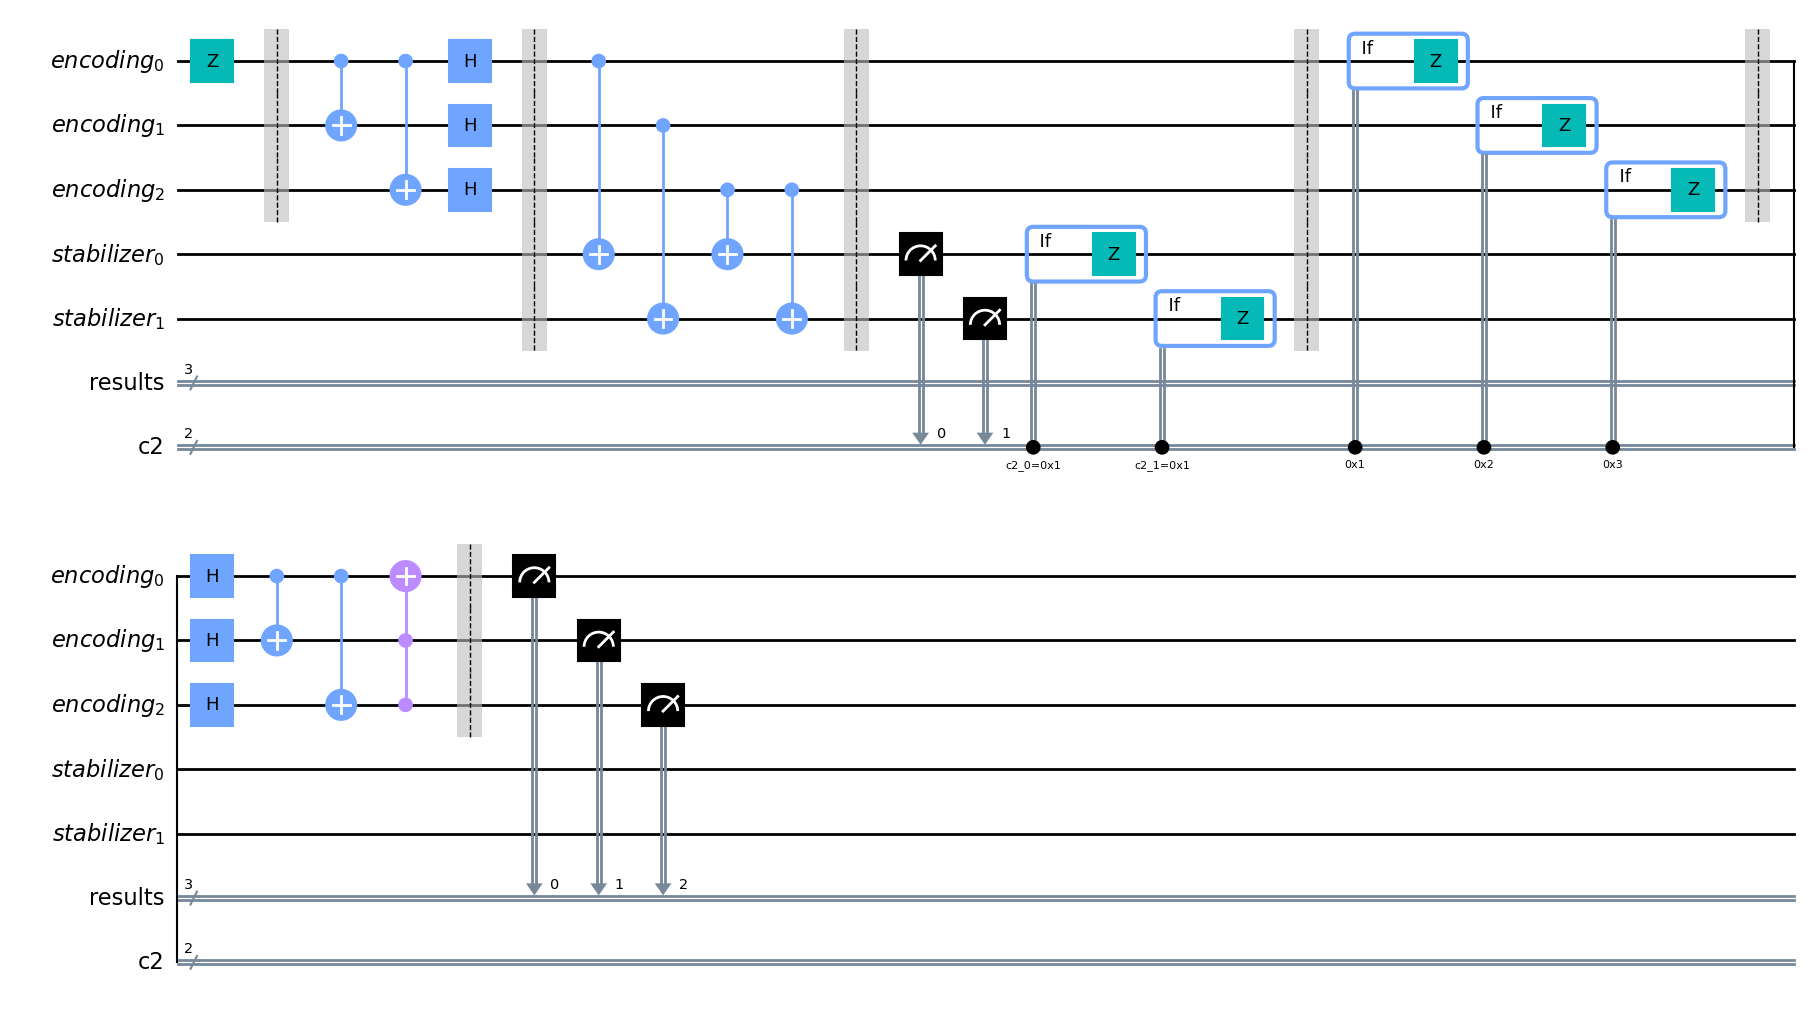

In [89]:
# 실험을 위한 기초 회로를 셋업합니다
encoding = QuantumRegister(3, name = "encoding")
stabilizer = QuantumRegister(2, name = "stabilizer")

encoding_q0, encoding_q1, encoding_q2 = encoding
stabilizer_q0, stabilizer_q1 = stabilizer

# 인코딩의 결과
results = ClassicalRegister(3, name = "results")

result_b0, result_b1, result_b2 = results

# 신드롬을 측정합니다
syndrome = ClassicalRegister(2, name = "syndrome")

syndrome_b0, syndrome_b1 = syndrome

# 인코딩된 실제 큐비트
state = encoding[0]

# state를 인코딩하기 위해 사용된 ancillas
ancillas = encoding[1:]


# Initializing
def initialize_circuit() -> QuantumCircuit:
    return QuantumCircuit(encoding, stabilizer, results, syndrome)

initial_state = initialize_circuit()

initial_state.z(encoding[0])
# Phase flip code를 이용한 인코딩
def encode_phase_flip(qc, state, ancillas):
    qc.barrier(state, *ancillas)
    for ancilla in ancillas:
        qc.cx(state, ancilla)
    qc.h(encoding[0])
    qc.h(encoding[1])
    qc.h(encoding[2])
    return qc


# 큐비트 인코딩 회로
encoding_circuit = encode_phase_flip(initialize_circuit(), state, ancillas)
                                    
# 디코딩(인코딩의 역과정입니다)
def decode_phase_flip(qc, state, ancillas):
    qc.barrier(state, *ancillas)
    qc.h(encoding[0])
    qc.h(encoding[1])
    qc.h(encoding[2])
    for ancilla in ancillas:
        qc.cx(state, ancilla)
    qc.ccx(encoding[2], encoding[1],encoding[0])
    return qc


decoding_circuit = decode_phase_flip(initialize_circuit(), state, ancillas)
# 하나의 큐비트 반전을 검출할 수 있는 회로를 stabilizer qubit을 이용해 세워봅시다
# 2개의 stabilizer qubit이 사용됩니다
# 0 = 00 에러가 발생하지 않음
# 1 = 01 에러가 qubit 0에서 발생함 (첫번째 큐비트)
# 2 = 10 에러가 qubit 1에서 발생함 (두번째 큐비트)
# 3 = 11 에러가 qubit 2에서 발생함 (세번째 큐비트)
def measure_syndrome_bit(qc, encoding, stabilizer):
    qc.barrier()
    encoding_q0, encoding_q1, encoding_q2 = encoding
    stabilizer_q0, stabilizer_q1 = stabilizer

    # 인코딩 회로
    qc.cx(encoding_q0, stabilizer_q0)
    qc.cx(encoding_q2, stabilizer_q0)
    qc.cx(encoding_q1, stabilizer_q1)
    qc.cx(encoding_q2, stabilizer_q1)

    qc.barrier()
    qc.measure(stabilizer, syndrome)
    with qc.if_test((syndrome_b0, 1)):
        qc.z(stabilizer_q0)
    with qc.if_test((syndrome_b1, 1)):
        qc.z(stabilizer_q1)

    return qc


syndrome_circuit = measure_syndrome_bit(initialize_circuit(), encoding, stabilizer)
# Correct the errors, remember how we encoded the errors above!
def apply_correction_bit(qc, encoding, syndrome):
    qc.barrier()
    encoding_q0, encoding_q1, encoding_q2 = encoding

    #########Insert your code here#############
    for i in range(0, encoding.size):
        with qc.if_test((syndrome, i + 1)):
            qc.z(encoding[i])
    ############################################

    return qc


correction_circuit = apply_correction_bit(initialize_circuit(), encoding, syndrome)
def apply_final_readout(qc, encoding, results):
    qc.barrier(encoding)
    qc.measure(encoding, results)
    return qc


measuring_circuit = apply_final_readout(initialize_circuit(), encoding, results)
complete_circuit = (
    initial_state.compose(encoding_circuit)
    .compose(syndrome_circuit)
    .compose(correction_circuit)
    .compose(decoding_circuit)
    .compose(measuring_circuit)
)
complete_circuit.draw(output="mpl")

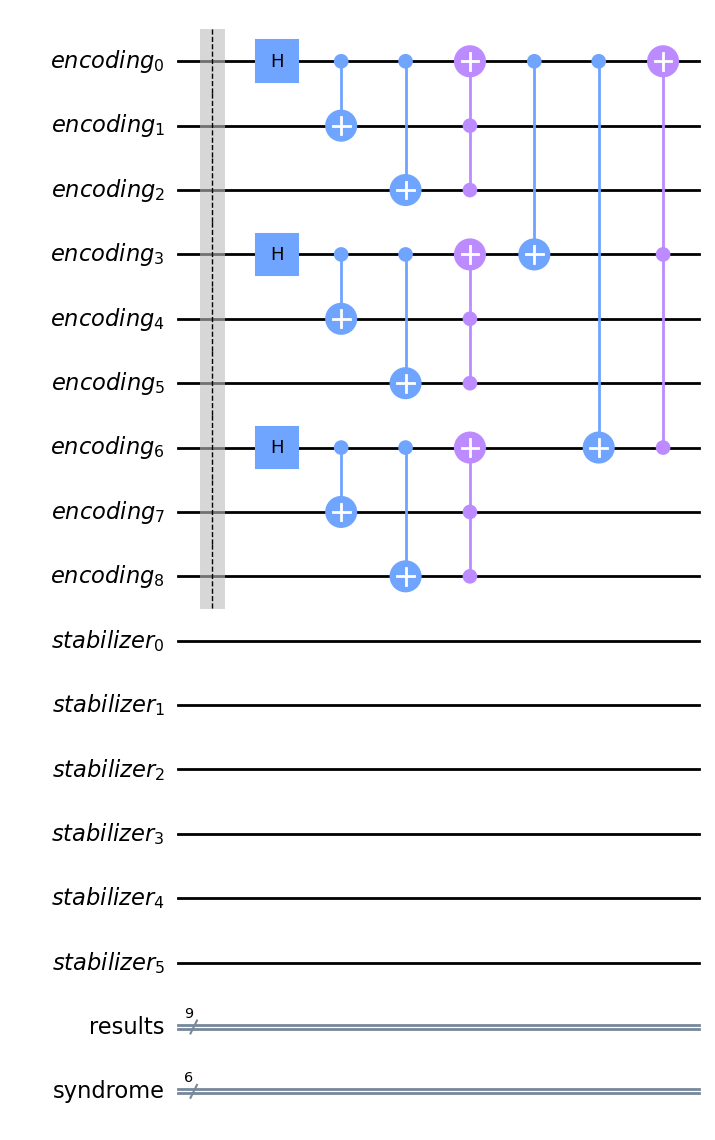

In [84]:
# 실험을 위한 기초 회로를 셋업합니다
encoding = QuantumRegister(9, name = "encoding")

encoding_q0, encoding_q1, encoding_q2, encoding_q3, encoding_q4, encoding_q5, encoding_q6, encoding_q7, encoding_q8 = encoding

# Stabilizer
stabilizer = QuantumRegister(6, name = "stabilizer")

stabilizer_q0, stabilizer_q1, stabilizer_q2, stabilizer_q3, stabilizer_q4, stabilizer_q5 = stabilizer

# 인코딩의 결과
results = ClassicalRegister(9, name = "results")

result_b0, result_b1, result_b2, result_b3, result_b4, result_b5, result_b6, result_b7, result_b8 = results

# 신드롬을 측정합니다
syndrome = ClassicalRegister(6, name = "syndrome")

syndrome_b0, syndrome_b1, syndrome_b2, syndrome_b3, syndrome_b4, syndrome_b5 = syndrome

# 인코딩된 실제 큐비트
state = encoding[0]

# state를 인코딩하기 위해 사용된 ancillas
ancillas = encoding[1:]

# state를 인코딩하기 위해 사용된 ancillas
ancillas1 = encoding[3], encoding[6]
ancillas2 = encoding[1:3]
ancillas3 = encoding[4:6]
ancillas4 = encoding[7:]


# Initializing
def initialize_circuit() -> QuantumCircuit:
    return QuantumCircuit(encoding, stabilizer, results, syndrome)

initial_state = initialize_circuit()

initial_state.x(encoding[0])
initial_state.z(encoding[0])
# Bit flip과 Phase flip을 인코딩합니다
def encode_phase_flip(qc, state, ancillas):
    qc.barrier(state, *ancillas1)
    for ancilla in ancillas1:
        qc.cx(state, ancilla)
    qc.h(encoding[0])
    qc.h(encoding[3])
    qc.h(encoding[6])
    for ancilla in ancillas2:
        qc.cx(encoding[0], ancilla)
    for ancilla in ancillas3:
        qc.cx(encoding[3], ancilla)
    for ancilla in ancillas4:
        qc.cx(encoding[6], ancilla)
    return qc


# 인코딩 회로
encoding_circuit = encode_phase_flip(initialize_circuit(), state, ancillas)
# 디코딩
def decode_phase_flip(qc, state, ancillas):
    qc.barrier(state, *ancillas1, *ancillas2, *ancillas3,*ancillas4)
    
    #############Insert your code here#####################
    qc.h(encoding[0])
    qc.h(encoding[3])
    qc.h(encoding[6])
    for ancilla in ancillas2:
        qc.cx(encoding[0], ancilla)
    for ancilla in ancillas3:
        qc.cx(encoding[3], ancilla)
    for ancilla in ancillas4:
        qc.cx(encoding[6], ancilla)
    qc.ccx(encoding[2], encoding[1],encoding[0])
    qc.ccx(encoding[5], encoding[4],encoding[3])
    qc.ccx(encoding[8], encoding[7],encoding[6])
    for ancilla in ancillas1:
        qc.cx(encoding[0], ancilla)
    qc.ccx(encoding[6], encoding[3],encoding[0])
    ##########################################################
    
    return qc


decoding_circuit = decode_phase_flip(initialize_circuit(), state, ancillas)
decoding_circuit.draw('mpl')

In [85]:
decoding_circuit.qasm()

'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg encoding[9];\nqreg stabilizer[6];\ncreg results[9];\ncreg syndrome[6];\nbarrier encoding[0],encoding[3],encoding[6],encoding[1],encoding[2],encoding[4],encoding[5],encoding[7],encoding[8];\nh encoding[0];\nh encoding[3];\nh encoding[6];\ncx encoding[0],encoding[1];\ncx encoding[0],encoding[2];\ncx encoding[3],encoding[4];\ncx encoding[3],encoding[5];\ncx encoding[6],encoding[7];\ncx encoding[6],encoding[8];\nccx encoding[2],encoding[1],encoding[0];\nccx encoding[5],encoding[4],encoding[3];\nccx encoding[8],encoding[7],encoding[6];\ncx encoding[0],encoding[3];\ncx encoding[0],encoding[6];\nccx encoding[6],encoding[3],encoding[0];\n'

In [87]:
qasm3.loads(qasm3.dumps(decoding_circuit))